## Implicit Volatility

#### We first get the market pricing of options 510050.SH ETF on date 2013-11-10

Considering options on ETF like 510050.SH ETF in our case, the expiration date is at the third Friday each month, we shall manually define a function for searching the exact expiration date corresponding to the contract month.

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import linregress, norm
from numpy import exp
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
data = pd.read_pickle('sse50_2023-11-10.pkl') # Read Historical data on 2013-11-10
data

,date,tradecode,exerciseprice,close,settlement_price,S0
1,2023-11-10,510050C2312A02400,2.40,0.1198,0.1198,2.49
2,2023-11-10,510050C2312A02450,2.45,0.0832,0.0832,2.49
3,2023-11-10,510050C2312A02500,2.50,0.0552,0.0552,2.49
4,2023-11-10,510050C2312A02550,2.55,0.0349,0.0349,2.49
5,2023-11-10,510050C2312A02600,2.60,0.0213,0.0213,2.49
...,...,...,...,...,...,...
102,2023-11-10,510050P2406A02650,2.65,0.1887,0.1887,2.49
103,2023-11-10,510050C2406A02700,2.70,0.0683,0.0683,2.49
104,2023-11-10,510050P2406A02700,2.70,0.2245,0.2240,2.49
105,2023-11-10,510050C2406A02750,2.75,0.0556,0.0556,2.49


In [9]:
option = data.copy()
option['contract_month'] = option['tradecode'].str[7:11]
option['CP'] = np.where(option['tradecode'].str[6:7] == "C", 0, 1)
option['ITM/OTM'] = np.where(((option["CP"]==0) & 
                              (option["exerciseprice"]>option["S0"]))|
                             ((option["CP"]==1) & 
                              (option["exerciseprice"]<option["S0"])),"0","1")
option

,date,tradecode,exerciseprice,close,settlement_price,S0,contract_month,CP,ITM/OTM
1,2023-11-10,510050C2312A02400,2.40,0.1198,0.1198,2.49,2312,0,1
2,2023-11-10,510050C2312A02450,2.45,0.0832,0.0832,2.49,2312,0,1
3,2023-11-10,510050C2312A02500,2.50,0.0552,0.0552,2.49,2312,0,0
4,2023-11-10,510050C2312A02550,2.55,0.0349,0.0349,2.49,2312,0,0
5,2023-11-10,510050C2312A02600,2.60,0.0213,0.0213,2.49,2312,0,0
...,...,...,...,...,...,...,...,...,...
102,2023-11-10,510050P2406A02650,2.65,0.1887,0.1887,2.49,2406,1,1
103,2023-11-10,510050C2406A02700,2.70,0.0683,0.0683,2.49,2406,0,0
104,2023-11-10,510050P2406A02700,2.70,0.2245,0.2240,2.49,2406,1,1
105,2023-11-10,510050C2406A02750,2.75,0.0556,0.0556,2.49,2406,0,0


In [10]:
def get_forth_Weds(contract_month): 
    # get the forth Wednesday on each month as the expiration date
    first_7D = pd.date_range("20"+contract_month+"01","20"+contract_month+"07") 
    # Get the first 7-days
    list_day = first_7D.weekday  # Index the first week
    first_Wed = list_day.get_indexer([2])  # Identify the index of Wednesday
    forth_Wed = first_7D[first_Wed] + pd.DateOffset(weeks = 3) 
    # Reschedule to the forth Wednesday
    return forth_Wed.values[0]


option["last_day"] = option["contract_month"].map(get_forth_Weds)
option["maturity"] = (option["last_day"] - option["date"])/ pd.to_timedelta(242,"D") 
# Assume 244 trading days per year
option

,date,tradecode,exerciseprice,close,settlement_price,S0,contract_month,CP,ITM/OTM,last_day,maturity
1,2023-11-10,510050C2312A02400,2.40,0.1198,0.1198,2.49,2312,0,1,2023-12-27,0.194215
2,2023-11-10,510050C2312A02450,2.45,0.0832,0.0832,2.49,2312,0,1,2023-12-27,0.194215
3,2023-11-10,510050C2312A02500,2.50,0.0552,0.0552,2.49,2312,0,0,2023-12-27,0.194215
4,2023-11-10,510050C2312A02550,2.55,0.0349,0.0349,2.49,2312,0,0,2023-12-27,0.194215
5,2023-11-10,510050C2312A02600,2.60,0.0213,0.0213,2.49,2312,0,0,2023-12-27,0.194215
...,...,...,...,...,...,...,...,...,...,...,...
102,2023-11-10,510050P2406A02650,2.65,0.1887,0.1887,2.49,2406,1,1,2024-06-26,0.946281
103,2023-11-10,510050C2406A02700,2.70,0.0683,0.0683,2.49,2406,0,0,2024-06-26,0.946281
104,2023-11-10,510050P2406A02700,2.70,0.2245,0.2240,2.49,2406,1,1,2024-06-26,0.946281
105,2023-11-10,510050C2406A02750,2.75,0.0556,0.0556,2.49,2406,0,0,2024-06-26,0.946281


To calculate the implied volatility, we first determine the risk-free rate and the forward price.
Referencing on the methodology proposed by the CBOE, we first calculate the discount factor and the forward price.
Using put-call parity, we calculate the implied forward price from the European-style call and put
prices around the at-the-money strike. For each maturity, we select the strikes satisfying the following
criteria: ATM – 8% to ATM + 8% and perform Linear Regression.

In [11]:
# Separating calls and puts
calls = option[option['CP'] == 0].copy()
puts = option[option['CP'] == 1].copy()

# Defining the index for a set of call and put option
calls['tradecode_prefix'] = calls['tradecode'].apply(lambda x: x[:6] + x[7:])
puts['tradecode_prefix'] = puts['tradecode'].apply(lambda x: x[:6] + x[7:])

merged_option = pd.merge(calls, puts, 
                         on=['tradecode_prefix', 'maturity'], 
                         suffixes=('_call', '_put'))
merged_option = merged_option[['date_call', 'tradecode_call', 'tradecode_put', 
                               'exerciseprice_call', 'close_call', 'close_put', 
                               'S0_call', 'maturity']]
merged_option.rename(columns={'close_call': 'Call Price', 'close_put': 'Put Price', 
                              'exerciseprice_call': 'K', 'S0_call': 'S0'}, 
                     inplace=True)

merged_option = merged_option.sort_values(by='maturity')
merged_option.head()

,date_call,tradecode_call,tradecode_put,K,Call Price,Put Price,S0,maturity
28,2023-11-10,510050C2311M02450,510050P2311M02450,2.45,0.0523,0.0101,2.49,0.049587
29,2023-11-10,510050C2311M02500,510050P2311M02500,2.50,0.0235,0.0308,2.49,0.049587
30,2023-11-10,510050C2311M02550,510050P2311M02550,2.55,0.0086,0.0660,2.49,0.049587
31,2023-11-10,510050C2311M02600,510050P2311M02600,2.60,0.0034,0.1113,2.49,0.049587
32,2023-11-10,510050C2311M02650,510050P2311M02650,2.65,0.0015,0.1588,2.49,0.049587


From Put-Call Parity, we have
$$ C + PV = P + S \Rightarrow P - C + S = PV$$

In [12]:
grouped = merged_option.groupby('maturity')
result = pd.DataFrame(columns=['maturity', 'Discount Factor', 'Dividend', 'Forward Price'])

for name, group in grouped:
    # Determine the ATM strike (closest to the underlying price)
    atm_strike = group.loc[(group['K'].sub(group['S0'].iloc[0]).abs().idxmin()), 'K']
    # Define the range of strikes within 8% of the ATM
    lower_bound = atm_strike * 0.92
    upper_bound = atm_strike * 1.08
    
    # Filter strikes within this range
    filtered_group = group[(group['K'] >= lower_bound) & (group['K'] <= upper_bound)]
    
    # Applying put-call parity
    filtered_group = filtered_group.copy()
    filtered_group['PC Parity'] = (filtered_group['Put Price'] - 
                                   filtered_group['Call Price'] + 
                                   filtered_group['S0'])
    # Linear regression to find alpha and beta
    if not filtered_group.empty:
        slope, intercept, r_value, p_value, std_err = linregress(
            filtered_group['K'], 
            filtered_group['PC Parity'])
        
        df = slope
        df_adj = df - 1
        div = intercept
        forward_price = (group['S0'].iloc[0] - div) / df

        temp_df = pd.DataFrame({
        'maturity': [name],
        'Discount Factor': [df_adj],
        'Dividend': [div],
        'Forward Price': [forward_price]
    })
        result = pd.concat([result, temp_df], ignore_index=True)
result

,maturity,Discount Factor,Dividend,Forward Price
0,0.049587,0.001119,-0.005113,2.492324
1,0.194215,0.001476,-0.015552,2.501859
2,0.570248,-0.011786,-0.003229,2.522963
3,0.946281,-0.020190,-0.000369,2.541687


In [13]:
option_updated_vol = pd.merge(option, result, how='left', on='maturity')
option_updated_vol

,date,tradecode,exerciseprice,close,settlement_price,S0,contract_month,CP,ITM/OTM,last_day,maturity,Discount Factor,Dividend,Forward Price
0,2023-11-10,510050C2312A02400,2.40,0.1198,0.1198,2.49,2312,0,1,2023-12-27,0.194215,0.001476,-0.015552,2.501859
1,2023-11-10,510050C2312A02450,2.45,0.0832,0.0832,2.49,2312,0,1,2023-12-27,0.194215,0.001476,-0.015552,2.501859
2,2023-11-10,510050C2312A02500,2.50,0.0552,0.0552,2.49,2312,0,0,2023-12-27,0.194215,0.001476,-0.015552,2.501859
3,2023-11-10,510050C2312A02550,2.55,0.0349,0.0349,2.49,2312,0,0,2023-12-27,0.194215,0.001476,-0.015552,2.501859
4,2023-11-10,510050C2312A02600,2.60,0.0213,0.0213,2.49,2312,0,0,2023-12-27,0.194215,0.001476,-0.015552,2.501859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2023-11-10,510050P2406A02650,2.65,0.1887,0.1887,2.49,2406,1,1,2024-06-26,0.946281,-0.020190,-0.000369,2.541687
102,2023-11-10,510050C2406A02700,2.70,0.0683,0.0683,2.49,2406,0,0,2024-06-26,0.946281,-0.020190,-0.000369,2.541687
103,2023-11-10,510050P2406A02700,2.70,0.2245,0.2240,2.49,2406,1,1,2024-06-26,0.946281,-0.020190,-0.000369,2.541687
104,2023-11-10,510050C2406A02750,2.75,0.0556,0.0556,2.49,2406,0,0,2024-06-26,0.946281,-0.020190,-0.000369,2.541687


In [14]:
def BSM(CP, S, X, sigma, T, r, b):
    d1 = (np.log(S/X) + (b + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * exp((b - r)*T) * norm.cdf(d1) - X * exp(-r*T) * norm.cdf(d2)
    put_price =  X * exp(-r*T) * norm.cdf(-d2) - S * exp((b - r)*T) * norm.cdf(-d1)
    value = call_price + CP * (put_price - call_price)
    return value


def newton_vol(C0, CP, S, X, T, r, b, vol_est = 0.25, n_iter=1000):
    for i in range(n_iter):
        d1 = (np.log(S/X) + (b + vol_est**2/2)*T) / (vol_est* np.sqrt(T))
        vega = S * exp((b-r)*T) * norm.pdf(d1) * T**0.5 
        vol_est = vol_est - (BSM(CP, S, X, vol_est, T, r, b) - C0) / vega
    return vol_est

In [15]:
option_updated_vol = option_updated_vol.copy()
option_updated_vol['market_imp_vol'] = newton_vol(C0=option_updated_vol['close'], 
                                                  CP = option_updated_vol['CP'], 
                                                  S = option_updated_vol['S0'], 
                                                  X = option_updated_vol['exerciseprice'], 
                                                  T = option_updated_vol['maturity'], 
                                                  r=option_updated_vol['Discount Factor'],
                                                  b = option_updated_vol['Discount Factor'] 
                                                  - option_updated_vol['Dividend'], 
                                                  vol_est = 0.25, 
                                                  n_iter=500)
option_updated_vol.head()

,date,tradecode,exerciseprice,close,settlement_price,S0,contract_month,CP,ITM/OTM,last_day,maturity,Discount Factor,Dividend,Forward Price,market_imp_vol
0,2023-11-10,510050C2312A02400,2.40,0.1198,0.1198,2.49,2312,0,1,2023-12-27,0.194215,0.001476,-0.015552,2.501859,0.134586
1,2023-11-10,510050C2312A02450,2.45,0.0832,0.0832,2.49,2312,0,1,2023-12-27,0.194215,0.001476,-0.015552,2.501859,0.128332
2,2023-11-10,510050C2312A02500,2.50,0.0552,0.0552,2.49,2312,0,0,2023-12-27,0.194215,0.001476,-0.015552,2.501859,0.127668
3,2023-11-10,510050C2312A02550,2.55,0.0349,0.0349,2.49,2312,0,0,2023-12-27,0.194215,0.001476,-0.015552,2.501859,0.128675
4,2023-11-10,510050C2312A02600,2.60,0.0213,0.0213,2.49,2312,0,0,2023-12-27,0.194215,0.001476,-0.015552,2.501859,0.130956


Verify the estimated volatility through the BS pricing formula

In [16]:
model_price = BSM(CP = option_updated_vol['CP'],
                  S =option_updated_vol['S0'],
                  X = option_updated_vol['exerciseprice'],
                  sigma = option_updated_vol['market_imp_vol'], 
                  T = option_updated_vol['maturity'],
                  r=option_updated_vol['Discount Factor'],
                  b=option_updated_vol['Discount Factor'] 
                  - option_updated_vol['Dividend'])
np.round(model_price - option_updated_vol['close'], 4).sum()

np.float64(0.0)

To graph the implied volatility, we choose the out-of-money options, whose value consists of only the time value (volatility and the maturity) but the instrinsic one. Meanwhile, we filter out the options with prices larger than tick size for a higher accuracy in plotting.

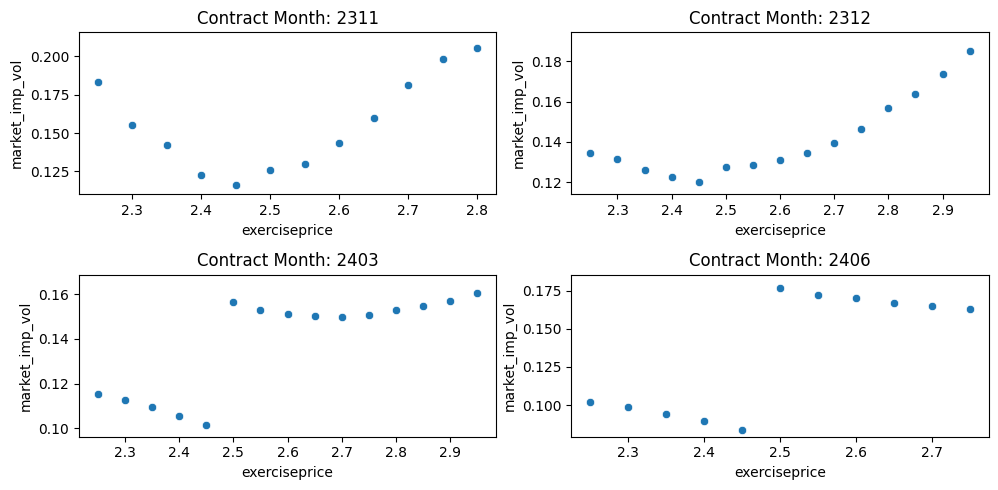

In [17]:
unique_contracts = np.sort(option_updated_vol['contract_month'].unique())
num_contracts = len(unique_contracts)

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()

for idx, contract_month in enumerate(unique_contracts):
    fit_option = option_updated_vol[(option_updated_vol['ITM/OTM'] == '0') & 
                                    (option_updated_vol['settlement_price'] > 0.0001) & 
                                    (option_updated_vol['contract_month'] 
                                     == contract_month)]
    
    sns.scatterplot(data=fit_option, x='exerciseprice', y='market_imp_vol', ax=axs[idx])
    axs[idx].set_ylim([fit_option['market_imp_vol'].min() * 0.95, 
                       fit_option['market_imp_vol'].max() * 1.05])
    axs[idx].set_title(f'Contract Month: {contract_month}')

plt.tight_layout()
plt.show()

In [42]:
def get_interplote_ivs_data(data):
    # Filter data to include only the first two unique maturities
    unique_maturities = sorted(data['maturity'].unique())[:2]
    data = data[data['maturity'].isin(unique_maturities)]

    # Sort data
    data = data.sort_values(["contract_month", "exerciseprice"])

    # Setup the grid for interpolation
    t_array = np.linspace(data['maturity'].min(), data['maturity'].max(), 20)
    k_array = np.linspace(data['exerciseprice'].min(), data['exerciseprice'].max() - 0.05, 50)
    t, k = np.meshgrid(t_array, k_array)
    v = np.zeros_like(k)

    # Interpolation for each maturity
    spline = []
    for m in unique_maturities:
        sample_strike = data[data['maturity'] == m]['exerciseprice']
        sample_volatility = data[data['maturity'] == m]['market_imp_vol']
        cs_k = CubicSpline(x=sample_strike, y=sample_volatility, bc_type="not-a-knot", extrapolate=True)
        spline.append(cs_k)

    # Calculate interpolated volatilities across the grid
    for t1 in enumerate(t_array):
        for k1 in enumerate(k_array):
            volatility_at_k1 = [float(cs(k1[1])) for cs in spline]
            cs = CubicSpline(x=unique_maturities, y=volatility_at_k1, bc_type="natural")
            volatility = float(cs(t1[1]))
            v[k1[0], t1[0]] = volatility
    return t, k, v

def plot_ivs(t, k, v):
    fig = go.Figure(data=[go.Surface(z=v, x=t, y=k, colorscale='magama')])
    fig.update_layout(
        title='Implied Volatility Surface',
        autosize=True,
        scene=dict(
            xaxis_title='Maturity',
            yaxis_title='Strike Price',
            zaxis_title='Implied Volatility'
        ),
        margin=dict(l=50, r=50, b=40, t=90, pad=4),
        height=600
    )
    fig.show()

# Assuming 'option_updated_vol' is your DataFrame filtered to 'ITM/OTM' == '0'
filtered_data = option_updated_vol[option_updated_vol['ITM/OTM'] == '0']
t, k, v = get_interplote_ivs_data(filtered_data)
plot_ivs(t, k, v)